In [1]:
!pip install mesa

In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

import random
np.random.seed(67890)
random.seed(67890)

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
MAXVAL = 10000

In [3]:
#Creamos los agentes "Caja"
class BoxAgent(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)

In [4]:
class RobotAgent(Agent):
  def __init__(self, id, model):
      super().__init__(id, model)
      self.totalMoves = 0
      self.carrying_box = None

  def move(self):
      options = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
      self.model.grid.move_agent(self, self.random.choice(options))
      self.totalMoves += 1

  def pickUp(self):
      if self.carrying_box is None:
          cell_contents = self.model.grid.get_cell_list_contents([self.pos])
          box_count = sum(1 for obj in cell_contents if isinstance(obj, BoxAgent))
          for obj in cell_contents:
              if isinstance(obj, BoxAgent) and box_count < 5:
                  self.carrying_box = obj
                  self.model.grid.remove_agent(obj)
                  return

  def putDown(self):
      if self.carrying_box is not None:
          cell_contents = self.model.grid.get_cell_list_contents([self.pos])
          box_count = sum(1 for obj in cell_contents if isinstance(obj, BoxAgent))
          if 1 < box_count < 5:
              self.model.grid.place_agent(self.carrying_box, self.pos)
              self.carrying_box = None

  #Función que lleva a cabo los pasos de la simulación (clean y move)
  def step(self):
    self.move()
    if self.carrying_box is None:
            self.pickUp()
    else:
        self.putDown()

In [5]:
#Función para dibujar una cuadrícula que nos permitirá visualizar nuestro modelo
def getGrid(model):
    #Creamos una matriz vacía (zeros) con las dimensiones de width y height (2D)
    grid=np.zeros( (model.grid.width, model.grid.height))
    for x in range(model.grid.width):
      for y in range(model.grid.height):
        if not model.grid.is_cell_empty((x, y)):
          contents = model.grid.get_cell_list_contents((x,y))
          if any(isinstance(agent,BoxAgent) for agent in contents):
            numBoxes = sum(1 for agent in contents if isinstance(agent, BoxAgent))
            if(numBoxes == 5):
              grid[x][y] = 2 #Asignar 2 si la torre está completa
            else:
              grid[x][y] = 1 #Asignar 1 si hay una caja en la celda
          elif any(isinstance(agent, RobotAgent) for agent in contents):
            for agent in contents:
              if isinstance(agent, RobotAgent):
                grid[x][y] = 4 #Asignar 4 si hay un agente robot con una caja en la celda
              else:
                grid[x][y] = 3 #Asignar 3 si hay un agente robot SIN caja en la celda
      else:
        grid[x][y] = 0 # Celda vacía
    return grid

In [6]:
#Creamos el modelo para la Robot
class RobotModel(Model):
  def __init__(self, width, height, numAgents=5, maxSteps=1000, numBoxes = 200):
    super().__init__()
    self.numAgents = numAgents
    self.numBoxes = numBoxes
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.cells = np.zeros((width, height))
    self.maxSteps = maxSteps
    self.timeNeeded = 0
    self.counter = 0


    #Bucle while para instanciar las cajas aleatoriamente en grupos de 1-3
    while self.numBoxes > 0: #Mientras haya cajas no asignadas
      boxesInSite = np.random.randint(1, 3) #Elegir aleatoriamente cuántas cajas se van a colocar en un lugar
      x = np.random.randint(0, self.grid.width) #elegir aleatoriamente un valor en anchura (coordenadas)
      y = np.random.randint(0, self.grid.height) #elegir aleatoriamente un valor en altura (coordenadas)

      # Verificar si ya hay cajas en las coordenadas elegidas
      cell_contents = self.grid.get_cell_list_contents((x, y)) #Revisar si hay cajas en una celda
      box_count = sum(1 for obj in cell_contents if isinstance(obj, BoxAgent)) #contar cuántas cajas hay en una celda

      if box_count==0: # Si no hay cajas en esta celda
        for i in range(boxesInSite): #Instanciamos la cantidad de cajas elegidas para esa coordenada
          agent = BoxAgent(i, self)
          self.grid.place_agent(agent, (x,y))
        self.numBoxes = self.numBoxes - boxesInSite #restamos a la cantidad total de numBoxes (cajas sin asignar)

    #Creamos los agentes y los colocamos en la casilla (1,1)
    for j in range(self.numAgents):
      emptyPositions = self.grid.empties
      position = self.random.choice(list(emptyPositions))

      # Verificar si ya hay cajas en las coordenadas elegidas
      #cell_contents = self.grid.get_cell_list_contents((x, y)) #Revisar si hay cajas en una celda
      #obj_count = sum(1 for obj in cell_contents if isinstance(obj, BoxAgent) and isinstance(obj, RobotAgent)) #contar cuántas cajas hay en una celda
      #if empty: # Si no hay cajas en esta celda
      agent = RobotAgent(j, self)
      self.grid.place_agent(agent, position)
      self.schedule.add(agent)

  def pilasDeCinco(self):
    self.counter = 0
    for x in range(model.grid.width):
      for y in range(model.grid.height):
        cell_contents = self.grid.get_cell_list_contents((x, y)) #Revisar si hay cajas en una celda
        obj_count = sum(1 for obj in cell_contents if isinstance(obj, BoxAgent)) #contar cuántas cajas hay en una celda
        if obj_count == 5: # Si no hay cajas en esta celda
          self.counter += 1
    return self.counter


#Función que lleva a cabo los pasos de la simulación
  def step(self):
    self.dataCollector.collect(self)
    self.schedule.step()
    self.running = False
    self.pilasDeCinco()
    self.timeNeeded += 1

In [7]:
#Definimos valores de las variables necesarias para coordinar y componer el modelo
np.random.seed(67890)

GRID_SIZE = 20

MAX_ITER = 1000

AGENT_NUM= 5

NUMBOXES = 200

startTime = time.time()

model = RobotModel(GRID_SIZE, GRID_SIZE, AGENT_NUM, MAX_ITER, NUMBOXES)

i = 0
while i < MAX_ITER:
  model.step()
  i = i + 1

In [8]:
#Despliege de los datos importantes.
totalTime = time.time() - startTime
#Imprimir el tiempo de ejecución de la simulación
print('Tiempo de ejecucion: %.5f segundos' % totalTime)
#Imprimir la cantidad de Steps necesarios para acabar de limpiar
print(f'Cantidad de Steps para que todas las celdas estén limpias: {model.timeNeeded} Steps')
#Imprimir la cantidad de torres de 5 que quedaron al final
print(f'Cantidad de Torres de 5 cajas: {model.counter} Pilas')

Tiempo de ejecucion: 1.85450 segundos
Cantidad de Steps para que todas las celdas estén limpias: 1000 Steps
Cantidad de Torres de 5 cajas: 27 Pilas


In [9]:
#Imprimimos toda la matriz de datos
all_grid = model.dataCollector.get_model_vars_dataframe()
print(all_grid)

                                                  Grid
0    [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
1    [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
2    [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
3    [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
4    [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
..                                                 ...
995  [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
996  [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
997  [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
998  [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...
999  [[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...

[1000 rows x 1 columns]


Working...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14968\1336012953.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap='magma')


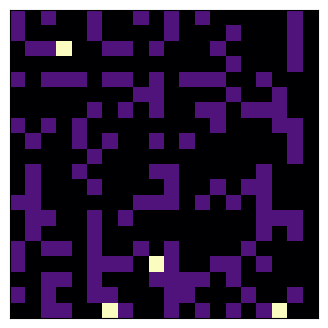

In [10]:
#Registramos los movimientos de los agentes en los steps y los animamos
#Asignamos el tamaño de la animación
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])

#Comprobamos que la matriz tenga datos
if not all_grid.empty:
  print("Working...")
  #Mostrar visualización de la simulación
  patch = plt.imshow(all_grid.iloc[0][0], cmap='magma')
else:
  #Si no hay datos, imprimimos un mensaje de error...
  print("ERROR: NO DATA")
  #... y la matriz vacía
  patch = plt.imshow(np.zeros((model.grid.width, model.grid.height)), cmap='magma')

#Animamos / Dibujamos la matriz con los datos que tenemos
def animate(i):
  #Mientras no se estén pasando los límites de la grid
  if i < len(all_grid):
    #Actualizar estados
    patch.set_data(all_grid.iloc[i][0])
  else:
    #Si no, mostramos el último estado
    patch.set_data(all_grid.iloc[-1][0])

#Mostramos la matriz como tal
anim = animation.FuncAnimation(fig, animate, frames=MAX_ITER, repeat=False)
plt.show()

In [11]:
#Ahora le añadimos movimiento y representación visual a nuestra simulación
anim

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14968\1336012953.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
